In [2]:
# load libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import glob 
import os

# see process_data.py
import process_data as data

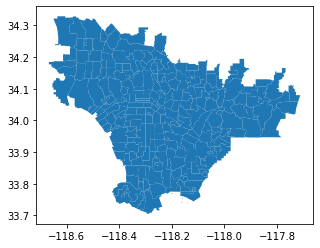

In [3]:
# load zipcodes (see r files)
zipcodes_shp = os.path.join("..", "processed", "collapsed_measures", "zipcodes_processed.shp") 
zipcodes = gpd.read_file(zipcodes_shp) 

zipcodes.plot()
plt.show()

In [4]:
# load acs data; map cols / data description to Data object from process_data module
# TODO create data dictionary? 
data_path = os.path.join("..", "data", "pca")

csvs_mapped = dict(
    foreign_born = data.Data(
        path=os.path.join(data_path, "ACSDP5Y2022.DP02-Data.csv"), 
        cols_to_extract=dict(
            DP02_0094PE = "ForeignBorn"
        ),
        cols_to_merge=None
    ),
    employment_poverty = data.Data(
        path=os.path.join(data_path, "ACSDP5Y2022.DP03-Data.csv"), 
        cols_to_extract=dict(
            DP03_0005E = "Unemployment" 
        ),
        cols_to_merge=dict(
            WorkOutdoors = ["DP03_0030E", "DP03_0031E"] # natural resources, construction, maintenance, production, transportation, material moving
        )
    ),
    population_ages = data.Data(
        path=os.path.join(data_path, "ACSDP5Y2022.DP05-Data.csv"), 
        cols_to_extract=dict(
            DP05_0001E = "TotalPop",
            DP05_0066M = "WhitePop",
            DP05_0067E = "BlackPop", 
            DP05_0069E = "AsianPop", # doesn't include native hawaiians and pacific islanders (ask abt it?)
            DP05_0068E = "NativePop", 
            DP05_0072PE = "HispanicLatino", 
            DP05_0024E = "Elderly", # 65 and over
            DP05_0019E = "Children" # under 18 
        ), 
        cols_to_merge=None
    ), 
    renting = data.Data(
        path=os.path.join(data_path, "ACSST5Y2022.S1101-Data.csv"), 
        cols_to_extract=dict(
            S1101_C01_019E = "Renting",
            S1101_C01_013E = "LiveAlone",
            S1101_C01_014E = "LiveAloneElderly" # live alone and >= 65 yrs old
        ), 
        cols_to_merge=None
    ), 
    education = data.Data(
        path=os.path.join(data_path, "ACSST5Y2022.S1501-Data.csv"),
        cols_to_extract=None,
        cols_to_merge=dict(
            LessThanHS = ["S1501_C01_002E", "S1501_C01_007E", "S1501_C01_008E"], # among those > 18
            MaxHS = ["S1501_C01_003E", "S1501_C01_009E"] # among those > 18
        )
    ), 
    poverty = data.Data(
        path=os.path.join(data_path, "ACSST5Y2022.S1701-Data.csv"),
        cols_to_extract=dict(
            S1701_C01_038E = "ExtremePoverty" # income is below 50% of poverty level
        ),
        cols_to_merge=None
    ),
    living_conditions = data.Data(
        path=os.path.join(data_path, "ACSST5Y2022.S2501-Data.csv"),
        cols_to_extract=None,
        cols_to_merge=dict(
            ManyOccupants = ["S2501_C01_003E", "S2501_C01_004E", "S2501_C01_005E"],
            Overcrowded = ["S2501_C01_007E", "S2501_C01_008E"] # defined as > 1.01 ppl/room: https://www.hcd.ca.gov/planning-and-community-development/housing-elements/building-blocks/overpayment-payment-and-overcrowding
        )
    )
)

In [42]:
# get overlap of all zipcodes across files 

# first, open up any csv and get zipcodes as reference 
ex_csv = csvs_mapped["foreign_born"]
ex_df = ex_csv.data_read_csv().drop([0]) # remove row with col name description
ex_df.reset_index(drop=True, inplace=True)

# get rows of relevant zipcodes
pattern = '|'.join(zipcodes["ZIPCODE"]) # regex of all zipcode ids; | = or
filtered_zips = ex_df[ex_df["NAME"].str.contains(pattern)]
filtered_zips.reset_index(drop=True, inplace=True)

# in NAME col, remove "ZCTA5"
filtered_zips.loc[:, "NAME"] = filtered_zips.loc[:, "NAME"].str.replace("ZCTA5 ", '')
filtered_zips = set(filtered_zips["NAME"])

In [43]:
copy = filtered_zips
len(copy)

250

In [44]:
# get intersection of zips w those of other files 
for val in csvs_mapped.values():
    df = val.data_read_csv().drop([0])
    
    # format zipcodes col
    df.loc[:, "NAME"] = df.loc[:, "NAME"].str.replace("ZCTA5 ", '')
    
    # get zips
    df_zips = df[df["NAME"].str.contains(pattern)].reset_index(drop=True)

    # get intersection of zips 
    filtered_zips = filtered_zips & set(df_zips["NAME"])

In [45]:
len(filtered_zips)
# copy == filtered_zips (true)

250

In [51]:
sorted_zips = sorted(filtered_zips)

  ZIPCODE                                           geometry
0   90001  POLYGON ((-118.24338 33.98924, -118.24333 33.9...
1   90002  POLYGON ((-118.23431 33.96101, -118.23425 33.9...
2   90003  POLYGON ((-118.28285 33.97597, -118.28285 33.9...
3   90004  POLYGON ((-118.28410 34.08349, -118.28425 34.0...
4   90005  MULTIPOLYGON (((-118.33541 34.06179, -118.3350...
       ZIPCODE                                           geometry
count      250                                                250
unique     250                                                250
top      90001  POLYGON ((-118.2433805350907 33.98923611416206...
freq         1                                                  1


<AxesSubplot:>

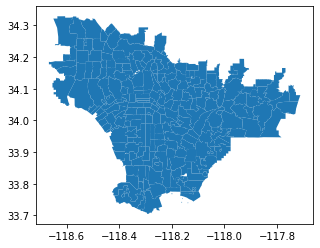

In [54]:
# plot the fiiltered_zips
filtered_geos = zipcodes[zipcodes.loc[:, "ZIPCODE"].isin(sorted_zips)].sort_values(by=["ZIPCODE"])

print(filtered_geos.head())
print(filtered_geos.describe())
filtered_geos.plot()

In [83]:
# dict to store all acs data
acs_data = dict()
acs_data["ZIPCODE"] = sorted_zips
acs_data["geometry"] = list(filtered_geos["geometry"])

In [85]:
# extract data 
for data in csvs_mapped: 
    print(f"Getting data for {data}...")
    data_obj = csvs_mapped[data]
    csv_df = data_obj.data_read_csv().drop([0])
    csv_df.reset_index(drop=True, inplace=True)

    # reformat zips
    csv_df.loc[:, "NAME"] = csv_df.loc[:, "NAME"].str.replace("ZCTA5 ", '')

    # get rows of relevant zipcodes
    filtered = csv_df[csv_df.loc[:, "NAME"].isin(sorted_zips)]
    filtered = filtered.sort_values(by=["NAME"])
    
    # extract cols and add to larger dict
    extracted_cols = data_obj.data_extract_cols(filtered)
    if (not extracted_cols.empty):
        acs_data.update(extracted_cols.to_dict(orient="list"))

    # merge columns together, add to larger dict
    merged_cols = data_obj.data_merge_cols(filtered)
    if (not merged_cols.empty):
        acs_data.update(merged_cols.to_dict(orient="list"))

Getting data for foreign_born...
Getting data for employment_poverty...
Getting data for population_ages...
Getting data for renting...
Getting data for education...
Getting data for poverty...
Getting data for living_conditions...


In [169]:
# add solar data (formatted dif)
solar = pd.read_csv(os.path.join(data_path, "ACSDT5Y2022.B25040-2024-07-22T232630.csv")).set_index("Label (Grouping)")

# select rows, cols
solar_filtered = solar.filter(like="Solar energy", axis=0).filter(like="Estimate", axis=1) # use filter for row bc there r weird indents
solar_filtered = solar_filtered.reset_index().drop("Label (Grouping)", axis=1)

# rename cols and transpose
solar_filtered.rename(columns=lambda col: col[5:11], inplace=True)
solar_final = solar_filtered.transpose().rename_axis("ZIPCODE").reset_index().rename(columns={0:"Solar"})
solar_final.head()


,ZIPCODE,Solar
0,90001,27
1,90002,34
2,90003,0
3,90004,57
4,90005,7


In [188]:
# get relevant zips
filtered_solar = solar_final[solar_final.loc[:, "ZIPCODE"].astype(str).isin(sorted_zips)]
filtered_solar.head()

In [192]:
# add to acs
acs_data.update(filtered_solar.to_dict(orient="list"))

In [193]:
# check df 
acs_df = pd.DataFrame.from_dict(acs_data)
acs_df.head()

,ZIPCODE,geometry,ForeignBorn,Unemployment,WorkOutdoors,TotalPop,WhitePop,BlackPop,AsianPop,NativePop,...,Children,Renting,LiveAlone,LiveAloneElderly,LessThanHS,MaxHS,ExtremePoverty,ManyOccupants,Overcrowded,Solar
0,90001,POLYGON ((-118.2433805350907 33.98923611416206...,40.9,2676,10628,57652,2238,4825,502,1675,...,17012,65.2,11.7,3.7,18722,10381,4360,12005,3980,27
1,90002,POLYGON ((-118.2343068083092 33.96100991986967...,34.7,2793,8441,53108,2379,8925,871,2320,...,15282,59.2,14.9,6.8,16227,10410,5323,11068,2999,34
2,90003,POLYGON ((-118.28284781820747 33.9759665503730...,39.8,3133,12442,75024,2734,13359,531,1150,...,23588,73.0,14.1,4.5,22594,14821,8356,15402,4238,0
3,90004,POLYGON ((-118.28410404339357 34.0834877835880...,46.5,2534,5217,58833,1776,3553,15464,1349,...,10842,83.5,31.9,7.3,10466,9174,5321,15689,4250,57
4,90005,MULTIPOLYGON (((-118.33541159329886 34.0617852...,54.1,1034,3469,37754,1538,2545,12798,1062,...,6565,92.2,42.1,10.5,8645,6685,3360,9610,3854,7


In [86]:
# convert to rates / shares, using acs population data 


In [ ]:
# impute 

In [ ]:
# do new data stuff guh...